## Collaborative Filtering: Matrix Factorization

- Check out: https://github.com/NicolasHug/Surprise

- In this example, we will explore building a MF model using explicit data (e.g. ratings). The scenario is given a dataset of users and courses they've viewed, recommend other courses a user may also be interested in. This example is basically a regression problem where we try to predict the ratings for each user and then recommend the highest predicted ratings. 

In [1]:
%cd ..

/Users/tracesmith/Desktop/Trace/Coding/user-recommender


In [2]:
%load_ext autoreload
%autoreload
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from recommender.utils.plots import plot_metrics

In [3]:
# Users Dataframe
users = pd.read_csv(os.path.join('data','user_course_views.csv'))
users = users.rename(columns={'user_handle':'user_id','course_id':'item_id'})

# Add Ratings Columns to Test Purposes
ratings = users[['user_id','item_id']].drop_duplicates()
ratings['rating'] = [np.random.randint(1,5) for i in range(ratings.shape[0])]

n_users = len(ratings['user_id'].unique())
n_items = len(ratings['item_id'].unique())

### Encode Labels

In [4]:
from typing import List
def encode_unique_ids(data:pd.DataFrame,cols:List[str]):
    """ Encode unique ids for user/items """
    for col in cols:
        data[col] = pd.Categorical(data[col]).codes
    return data 

# Create mappings for unique user and item ids
ratings = encode_unique_ids(ratings,['user_id','item_id'])

### Train/Test Split

In [5]:
def split_train_test(data:pd.DataFrame, split_ratio:float) -> np.ndarray:
    """ Split Train/Test Dataset"""
    idx = int(np.ceil(len(ratings) * split_ratio))
    train,test = data[:-idx], data[-idx:]
    print(f'Train Shape: {train.shape} -- Test Shape: {test.shape}')
    return train,test
    
train,test = split_train_test(ratings,split_ratio=0.20)

Train Shape: (84282, 3) -- Test Shape: (21071, 3)


### Matrix Factorization Model

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and items embedding matrix $V$, such that $A \approx UV^\top$ with

$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of items,
- $A_{ij}$ is the rating of the $j$th items by the $i$th user,
- Each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- Each row $V_j$ is a $d$-dimensional vector (embedding) representing items $j$,
- Predictions: for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

### Calculate Error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

### Train Matrix Factorization Model using Stochastic Gradient Descent with Keras

- The user-movie rating matrix is high dimensional and sparse, therefore I am going to reduce the dimensionality to represent the data in a dense form.
- Using matrix factorisation a large matrix can be estimated/decomposed into two long but slim matrices. 
- With gradient descent it is possible to adjust these matrices to represent the given ratings. 
- The gradient descent algorithm finds latent variables which represent the underlying structure of the dataset. Afterwards these latent variables can be used to reconstruct the original matrix and to predict the missing ratings for each user.
- In this case the model has not been trained to convergence and is not hyperparameter optimized.

### Build Sparse Matrix

In [6]:
def user_item_matrix(data:pd.DataFrame):
    """ Generate User/Item Matrix"""
    user_item_matrix = data.pivot_table(index='user_id', columns='item_id', values='rating')
    print('Shape User-Courses-Matrix:\t{}'.format(user_item_matrix.shape))
    return user_item_matrix
    
user_item_train = user_item_matrix(train)

Shape User-Courses-Matrix:	(7033, 5680)


### Train Model

In [ ]:
%autoreload
from recommenders.mf import MatrixFactorization
MF = MatrixFactorization(n_users, n_items, epochs=50, learning_rate=0.001, dropout=0.20, batch_size=64, embedding_dim=25)

In [15]:
MF = MatrixFactorization(n_users, n_items, epochs=50, learning_rate=0.001, batch_size=64, embedding_dim=25)

In [16]:
%time history = MF.train([train['user_id'],train['item_id']], train['rating'])

2021-07-28 15:57:42.492394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
1186/1186 [==============================] - 3s 2ms/step - loss: 1.5830 - val_loss: 1.2873
Epoch 2/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.2622 - val_loss: 1.2583
Epoch 3/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.2304 - val_loss: 1.2610
Epoch 4/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.1970 - val_loss: 1.2773
Epoch 5/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.1775 - val_loss: 1.2825
Epoch 6/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.1637 - val_loss: 1.2807
Epoch 7/50
1186/1186 [==============================] - 2s 2ms/step - loss: 1.1548 - val_loss: 1.3118
CPU times: user 50.9 s, sys: 8.3 s, total: 59.2 s
Wall time: 16.9 s


### Evaluate Model

/Users/tracesmith/Desktop/Trace/Coding/user-recommender/recommender/utils/plots.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_cols, idx + 1)


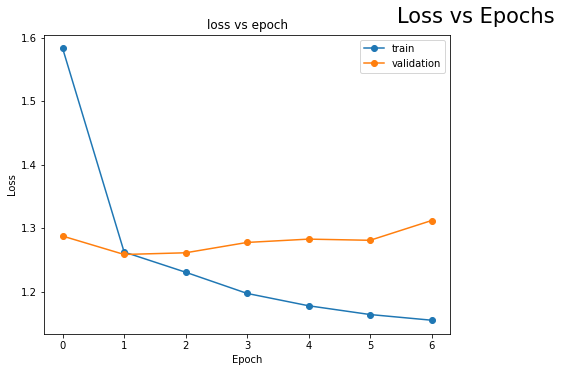

In [17]:
%autoreload
plot_metrics(history,metrics=['loss'])

### Make Recommendation

- Recommend topK items to user

In [18]:
weights = MF.model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]